In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

# Convolutions

* Repaso de trabajo con imagenes

## Dataset de imagenes

* CIFAR-10: clasico de computer vision
* consiste de 60,000 imagenes de 32x32 a color (RGB), etiquetadas con un entero que corresponde a 10 clases:
    * 0 - avion
    * 1 - carro
    * 2 - pajaro
    * 3 - gato
    * 4 - venado
    * 5 - perro
    * 6 - sapo
    * 7 - caballo
    * 8 - barco
    * 9 - camion
    
* las imagenes fueron recolectadas y etiquetadas por Krizhevsky, Nair y Hinton de CIFAR (Canadian Institute for Advanced Research)
* son un subset de una coleccion mas grande de imagenes a color de 32x32 no etiquetadas
    * "80 million tiny images dataset"
    * CSAIL (Computer Science and Artificial Intelligence Laboratory) de MIT
* Ya es considerada demasiado simple

### Descargar CIFAR10

In [1]:
from torchvision import datasets

data_path = "../data/cifar10/"

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

0it [00:00, ?it/s]

100%|█████████▉| 170434560/170498071 [01:40<00:00, 1761194.10it/s]

Files already downloaded and verified


170500096it [02:00, 1761194.10it/s]                               

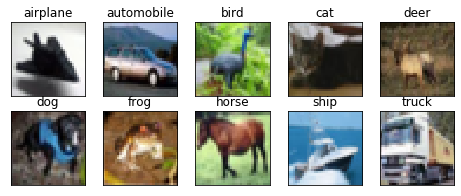

In [12]:
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

fig = plt.figure(figsize=(8,3))
num_classes = 10

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

* El modulo de `datasets` nos da acceso a los datasets de computer vision mas populares:
    * MNIST
    * FashionMNIST
    * CIFAR-100
    * SVHN
    * Coco
    * Omniglot
* En todos los casos son retornados como subclases de `torch.utils.data.Dataset`.
* Podemos ver que el _method resolution order_ de nuestra instancia `cifar10` lo incluye como su clase base

In [3]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 object)

### La clase Dataset

* Un Dataset de PyTorch es un objeto que requiere que se implementen dos metodos:
    * `__len__`: debe retornar el  numero de items en el dataset
    * `__getitem__`: debe retornar el item, consistiendo de una muestra y su etiqueta correspondiente (un entero)
    
```
__len__() -> len(a_dataset)

__getitem__(4) -> a_dataset[4]
```

* En practica cuando un objeto de Python esta equipado con el metodo `__len__`, podemos pasarlo como un argumento a la funcion `len` de python

In [4]:
len(cifar10)

50000

De igual forma, como el loader esta equipado con el metodo `__getitem__`, podemos usar el subscript estandar para indexar tuplas y listas para accesar items individuales.

En este caso obtenemos una imagen `PIL` con nuestro output deseado, un entero con valor 1, correspondiente a un "carro".

In [13]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F8B9829A050>,
 1,
 'automobile')

La muestra en el dataset `data.CIFAR10` es una instancia de una imagen RGB PIL. 

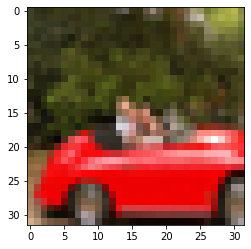

In [14]:
plt.imshow(img)
plt.show()

### Dataset Transforms

* Como es una imagen de PIL necesitamos una manera de convertirla a un tensor de PyTorch antes de poder hacer algo.
* Aqui entra el moduleo `torchvision.transforms`
    * funciones (objetos) componibles que pueden pasarse como un argumento a un dataset de `torchvision`
    * realizan las transformaciones sobre la data despues de cargarla pero antes de regresarla por `__getitem__`

In [15]:
from torchvision import transforms

dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'transforms']

* Podemos ver que hay un metodo `ToTensor`
    * una vez instanciado puede ser llamado como funcion con la imagen PIL como argumento
    * retorna un tensor como output

In [16]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.size()

torch.Size([3, 32, 32])

La imagen se transformo a un tensor 3x32x32, por tanto es una imagen de 3 canales (RGB) y 32x32

Podemos pasar el transform directo como un argumento al `dataset.CIFAR10`

In [17]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                  transform=transforms.ToTensor())

Luego de esto, accesar un elemento del dataset va a retornar un tensor en vez de una imagen PIL:

In [18]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

Como esperado, la forma tiene el canal como primera dimension, mientras que el tipo de escalar es `flaot32`

In [19]:
img_t.size(), img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

* Los valores de la imagen PIL original tenian un rango [0,255] (8-bit por canal)
* El transform `ToTensor` cambio la data a 32-bit floating point por canal
* escalo los valores a [0.0, 1.0]

In [20]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

Verifiquemos que es la misma imagen:

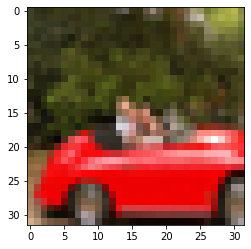

In [21]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

Lo es, pero tuvimos que usar `permute` para cambiar el orden de los ejes de CxHxW a HxWxC para pasarle a Matplotlib las dimensiones en el orden que las espera.

### Normalizar la data

* Los transforms son utiles porque podemos encadenar varios usando `transforms.Compose`
    * De esta forma podemos manejar la normalizacion y la aumentacion de data de forma transparente y directa en el data loader
* Por ejemplo, es buena practica normalizar el dataset para que cada canal tenga $\mu = 0$ y $\sigma = 1$
    * Si escogemos funciones de activacion que son lineales alrededor de 0 +- 1 (o 2), mantener la data en el mismo rango quiere decir que es mas probable que las neuronas tengan gradientes $\neq 0$ y por tanto van a aprender antes.
    * Asimismo, normalizar cada canal para que tenga la misma distribucion va a asegurar que la informacion del cana puede ser mezclada y actualizada con gradient descent usando el mismo learning rate.

Como CIFAR-10 es pequenio, podemos manipular todo en memoria. Vamos a apilar todos los tensores en el dataset a lo largo de una dimension extra:

In [22]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.size()

torch.Size([3, 32, 32, 50000])

Ahora podemos calcular la media por canal:

In [26]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4915, 0.4823, 0.4468])

Lo mismo para la desviacion estandar

In [28]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

Con estos numeros podemos inicializar la tranformacion `Normalize`

In [29]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

Y concatenarlo luego del transform `ToTensor`

In [31]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                      transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                               (0.2470, 0.2435, 0.2616))
                                      ]))

In [32]:
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

Noten que, despues de esto, plotear una imagen del dataset no nos va a proveer con una buena representacion de la imagen actual:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


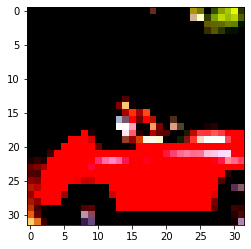

In [33]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1,2,0))
plt.show()

Esto es porque la normalizacion ha cambiado los niveles de RGB fuera del rango [0.0, 1.0] y tambien las magnitudes generales de los canales.

Toda la data sigue ahi, es solo que Matplotlib la representa como negra.

### Creando el dataset

* El primer paso es tener la data en la forma correcta.
* Podriamos hacer una sublcase que solo incluya pajaros y aviones
* En vez de eso, la solucion facil es filtrar la data en `cifar10` y remapear las etiquetas

In [34]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

## El uso de Convolutions

* Un modelo lineal entrenado en imagenes tiende a overfit el training set por la configuracion de fully connected layers
* Necesita detectar varias posibles traslaciones de objetos en la imagen
    * Esto necesita mucho parametros
    * lo que causa que se mas facil para el modelo memorizar el training set
* No hay independencia de la posicion
    * Hace que generalizar sea mas dificil

**Hay una mejor manera**

* Reemplazar las fully connected layers de la NN con una operacion lineal diferente: convolutions
* `nn.Linear`: Tomar una vista 1D de una imagen y multiplicarla con una weight matrix de `n_output_features x n_input_features`
    * tomar todos los pixeles de la imagen y, por cada canal calcular la suma ponderada de todos los pixeles multiplicados por un set de weights, uno por output feature.
* Si queremos reconocer patrones correspondientes a un objeto, necesitamos ver como estan arreglados pixeles cercanos
    * Y estariamos menos interesados en en como pixeles separados aparecen en combinacion.
* En esencia, no importa si la imagen con el objeto que queremos detectar tiene un arbol, nube, carro en la esquina o no

* Para trasladar esta intuicion a forma matematica podriamos:
    * calcular la suma ponderada de cada pixel con sus vecinos inmediatos, en vez de con todos los otros pixeles.
    * Esto seria equivalente a construir weight matrices, una por output feature y ubicacion del output pixel.
    * En este caso todos los weights despues de cierta distancia de un pixel central serian cero.
* Hay una ultima propiedad deseada: 
    * queremos que estos patrones localizados tengan un efecto en el output sin importar su ubicacion en la imagen
    * esto se llama translation-invariant.

### Entonces que es una convolution?

Una convolution, o mas preciso una convolution discreta (hay una version continua), se define para una imagen de 2D como el producto escalar de un weight matrix, llamado el _kernel_, con todos los vecinos en el input. 

Consideren un kernel de 3x3 (en deep learning se acostumbra a usar kernels pequenios) como un tensor 2D:

In [ ]:
weight = torch.tensor([w00, w01, w02],
                      [w10, w11, w12],
                      [w20, w21, w22])

y una imagen MxN de 1 canal:

In [ ]:
image = torch.tensor([[i00, i01, i02, i03, ..., i0N],
                      [i10, i11, i12, i13, ..., i1N],
                      [i20, i21, i22, i23, ..., i2N],
                      [i30, i31, i32, i33, ..., i3N],
                      ...
                      [iM0, iM1, iM2, iM3, ..., iMN]])

Podemos calcular un elemento de la imagen de output (sin bias) como:

In [ ]:
o11 = i11 * w00 + i12 * w01 + i22 * w02 +
      i21 * w10 + i22 * w11 + i23 * w12 +
      i31 * w20 + i32 * w21 + i33 * w22

### DIBUJO

* Es decir, estamos "trasladando" el kernel en la ubicacion `i11` del input image, y multiplicamos cada peso con el valor de input image en su ubicacion correspondiente.
* Por tanto, el output image es creada al trasladar el kernel sobre todas las ubicaciones del input y realizar una suma ponderada.
* Para imagenes multi-canal, como nuestras imagenes RGB, el weight matrix seria una matriz 3x3x3,
    * i.e. un set de weights por cada canal, contribuyendo en conjunto a los valores del output

* Notese que el mismo kernel, y por tanto cada weight en el kernel, es reusado a traves de toda la imagen.
* Pensando de regreso al Autograd:
    * esto quiere decir que el uso de cada weight tiene una historia que incluye la imagen entera.
    * por tanto, la derivada del los w.r.t a un convolution weight incluye contribuciones de la imagen entera.

Entonces, una convolution es equivalente a aplicar multiples operaciones lineales, cuyos pesos son cero casi en todos lados excepto alrededor de pixeles individuales y reciben actualizaciones equivalentes durante el entrenamiento.

### En resumen:

Al cambiar a convolutions optuvimos:
* operaciones locales sobre vecinos
* translation-invariance
* modelos con mucho menos parametros

El insight clave en el tercer punto es que, con una convolution layer, el numero de parametrso no depende en el numero de pixeles en la imagen, como lo hace en un modelo fully connected.

Depende en el convolution kernel (3x3, 5x5, etc) y en cuantos convolution filters (o output channels) decidimos usar en nuestro modelo.

## Convolutions en accion

* El modulo `torch.nn` provee convolutions de 1,2 y 3 dimensiones:
    * `nn.Conv1d` para series de tiempo
    * `nn.Conv2d` para imagenes
    * `nn.Conv3d` para videos
* Para el dataset de CIFAR-10 vamos a usar `nn.Conv2d`. Como minimo los argumentos necesarios son:
    * numero de features. En este caso **channels** porque estamos tratando con imagenes multi-canal, i.e. mas de un valor por pixel.
    * numero de output features,
    * tamanio del kernel
* Por ejemplo, para nuestra primera convolutional layer vamos a tener:
    * 3 input features por pixel (los canales de RGB)
    * un numero arbitrario de canales en el output, por ejemplo 16
    * Mientras mas canales en la imagen de output, mas capacidad del network.
    * kernel de 3x3

In [ ]:
# el kernel_size de 3 es un shortcut para "3 en cada dimension"
# en este caso 2D, entonces 3x3
# de lo contrario pueden pasar una tupla e.i. (3,3)
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Podemos esperar un `weigt` tensor con el tamanio de la siguiente manera:
* Vamos a tener la misma cantidad de kernels, de tamanio `n_input_channels x 3 x 3`, que el numero de output channels
* Es decir, esperamos que el `weight` tensor sea de tamanio `n_input_channels x3x3x n_output_channels`, entonces `3x3x3x16`
* El bias como siempre es un valor constante que sumamos a cada canale en el output image, 16

In [ ]:
conv.weight.size(), conv.bias.size()

Podemos ver porque los convolutions son convenientes para aprender de imagenes:
* Tenemos modelos mas pequenios,
* buscando patrones locales,
* cuyos pesos estan optimizados a traves de la imagen entera

* Un pase de una 2D convolution produce una imagen 2D como output.
* Los pixeles son una suma ponderada sobre la imagen de input.
* En nuestro caso, los weights del kernel y el bias se inicializan de forma aleatoria
    * Por esta razon, la imagen de output no va a hacer sentido.
* Como es costumbre, agregamos la dimension 0 (correspondiente al batch) con `unsqueeze`
    * Esto se debe a que `nn.Conv2d` espera un tensor de forma `BxCxHxW` como input

In [ ]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).size(), output.size()

Podemos ver el output despues de un convolution

In [ ]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

* El output es mas pequenio
    * `torch.Size([1, 16, 30, 30])`
* Perdimos un par de pixeles en el proceso
* Porque?

* Es un efecto secundario de decidir que hacer en la orilla de la imagen.
* Aplicar un convolution kernel como una suma ponderada sobre pixeles en un vecindario de 3x3 requiere que hayan vecinos en todas las direcciones.
* Si estamos en `i00` solo tenemos pixeles a la derecha y hacia abajo.
* Por default, PyTorch se va a saltar los pixeles en la orilla
    * por tanto va a producir imagenes que son la mitad del ancho del convolution kernel mas pequenias en cada lado.
    * en nuestro caso `3//2 = 1`
    * Esto explica porque nos hacen faltas dos pixeles en cada dimension

* PyTorch nos da la posibilidad de hacer **_padding_** sobre la imagen.
    * crea pixeles fantasma alrededor del borde que tienen valor de 0 para el convolution.
* Por ejemplo, especificar `padding=1` cuando el `kernel_size=3` quiere decir que:
    * Ahora `i00` tiene un extra set de vecinos arriba y a su izquierda
    * Ahora podemos calcular un output del convolution aun en la esquina de la imagen original
    * el resultado es que el output tiene el mismo tamanio que la imagen original

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).size(), output.size()

* Noten el tamanio del `weight` y el `bias` no cambian se use o no padding.
* El `weight` y `bias` son `Parameters` que van a ser aprendidos a traves de backprop
    * de la misma forma que sucede para los `weights` y `bias` en `nn.Linear`
* Pero podemos jugar con convolutions configurando los weights a mano para ver que pasa
    * Primero vamos a hacer cero el `bias`
    * Luego vamos a poner los `weights` para que cada pixel en el output obtenga la media de sus vecinos, por cada vecindario 3x3

In [ ]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

Ahora miremos el efecto en una imagen de CIFAR

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

* El filtro produjo una version borrosa de la imagen.
* Cada pixel en el output es un promedio de un vecindario del input
    * esto causa que los pixeles del output esten correlacionados y cambien de manera mas suave

Podemos probar algo diferente:

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

Calculando la suma ponderada de un pixel arbitrario en posicion `2,2` como hicimos arriba, obtenemos:

In [ ]:
o22 = i13 - i11 +
      i23 - i21 +
      i33 - i31

* Esto calcula la diferencia de todos los pixeles a la derecha de `i22`, menos los pixeles a la izquierda de `i22`.
* En caso que haya un frontera entre dos regiones adyacentes de intensidad diferente
    * `o22` va a tener un valor alto
* Si aplicamos el kernel a una region de intensidad uniforme
    * `o22` va a ser cero.
* Esto se conoce como un edge detection kernel:
    * El kernel indica las fronteras verticales entre dos regiones horizontalmente adyacentes

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

* El convolution kernel hace mas obvias las fronteras verticales.
* Podriamos crear filtros mas elaborados
    * detectar fronteras verticales, diagonales
    * patrones
    * en este caso detectar, quiere decir el el output va a tener una magnitud grande
* En DL, dejamos que los kernels sean aprendidos de la data de tal manera que la discriminacion sea la mas efectiva.
    * Por ejemplo, en terminos de nuestra loss function aplicada al output y al valor real
* Desde este punto de vista, el trabajo de un convolutional NN es estimar el kernel de un banco de filtros en layers sucesivas
    * el kernel va a transformar una imagen multi-canal a otra imagen multi-canal
    * donde los diferentes canales van a corresponder a diferentes features (un canal para el promedio, otro para fronteras verticales, etc)

### Depth y Pooling

* Usamos convolutions para lograr locality y translation-invariance
* Luego utilizamos kernels pequenios como `3x3` o `5x5`
* Pero, como sabemos que todas las estructuras en nuestras imagenes caben en kernels de 3x3 o 5x5?
    * No lo sabemos porque no caben
* Entonces, como van los NNs a encontrar patrones mas grandes?

* En los ConvNets usamos stacks varias convolutions sucesivas.
* Al mismo tiempo hacemos downsampling de la imagen entre cada convolution layer
* El resultado de esto es que:
    * el primer conjunto de kernels opera en pequenios vecindarios en features de bajo nivel
    * el segundo conjunto de kernels opera sobre vecindarios mas grandes, produciendo features que son composiciones de features previos
    * asi sucesivamente
* Esto permite al ConvNet ver escenas complejas

![convnet features](../assets/conv_features.png)

* El downsampling puede ocurrir de diferentes formas. Por ejemplo, podriamos:
    * Promediar todos los pixeles. Un approach que fue al principio bastante comun.
    * Tomar el maximo de los pixeles. El que se usa con mas frequencia pero descarta data.

* Intuitivamente los outputs del convolution layer, tienden a tener alta magnitud donde ciertas features correspondientes al kernel estimado son detectadas.
    * Por ejemplo, fronteras verticales
* Al mantener el valor mas alto en el downsampled output, nos estamos asegurando que los features que han sido encontrados van a sobrevivir el downsampling

* Max-pooling esta en el modulo `nn.MaxPool2d`
    * igual que las convolutions hay versiones 1d y 3D
* Toma el input del tamanio sobre el cual va a operar la operacion de pooling.
* Si queremos downsample nuestra imagen a la mitda, vamos a usar un size de 2.

In [ ]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).size(), output.size()